In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications.densenet import DenseNet169
from keras.applications.densenet import preprocess_input


## Inisialisasi Awal

In [2]:
class_names = ['BIO','Cardboard','Electronic','Glass','Metal','Paper','Plastic','Trash']
nb_classes = len(class_names)
image_size = (150,150)

## Load Dataset

In [3]:
def load_data():

    datasets = ['data']
    images = []
    labels = []

    # iterate through training and test sets
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['BIO']: label = 0
            if folder in ['Cardboard']: label = 1
            elif folder in ['Electronic']: label = 2
            elif folder in ['Glass']: label = 3
            elif folder in ['Metal']: label = 4
            elif folder in ['Paper']: label = 5
            elif folder in ['Plastic']: label = 6
            elif folder in ['Trash']: label = 7

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the| img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [4]:
images, labels = load_data()

100%|██████████| 600/600 [00:06<00:00, 96.70it/s] 


In [167]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size = 0.8,)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [168]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

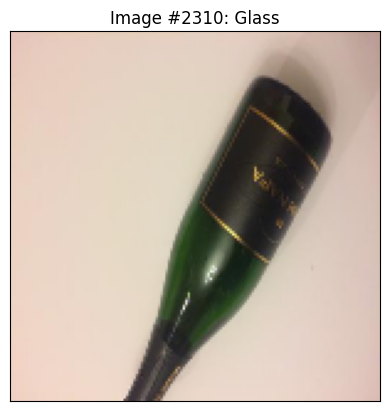

In [189]:
def display_random_image (class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

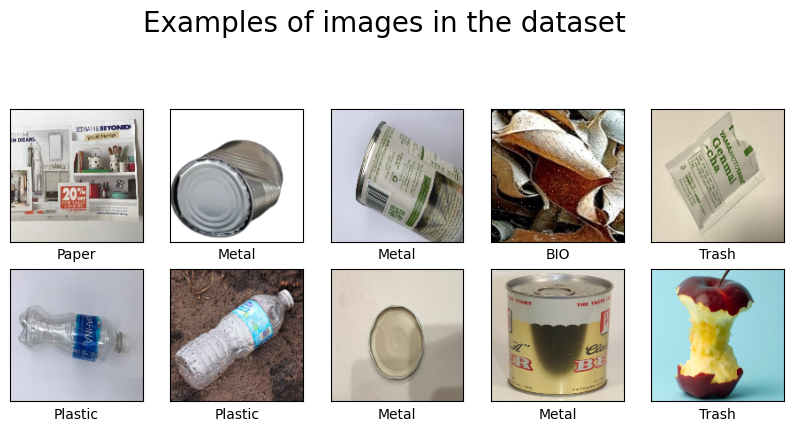

In [170]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=20)
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

## Load Pre Trained Model

In [171]:
pre_trained_model = tf.keras.applications.DenseNet169(input_shape=(150, 150, 3), include_top=False, weights="imagenet")

In [172]:
pre_trained_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 zero_padding2d_14 (ZeroPad  (None, 156, 156, 3)          0         ['input_8[0][0]']             
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 75, 75, 64)           9408      ['zero_padding2d_14[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1/conv[0][0]']

In [173]:
for layer in pre_trained_model.layers:
  layer.trainable = False
  print(layer.name)

input_8
zero_padding2d_14
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_15
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
con

## Lapisan Fully Connected

In [174]:
#Penambahan layer dropout 0.5 dan layer dense 128
last_layer = pre_trained_model.get_layer('relu')
last_output = last_layer.output
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(8, activation='softmax')(x)

In [175]:
model = tf.keras.Model(pre_trained_model.input, x)

In [176]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [177]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 zero_padding2d_14 (ZeroPad  (None, 156, 156, 3)          0         ['input_8[0][0]']             
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 75, 75, 64)           9408      ['zero_padding2d_14[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1/conv[0][0]']    

In [178]:
#Perubahan hanya pada learning rate dari 0.00001 diubah menjadi 0.000001
checkpoint = ModelCheckpoint(filepath='models.h5', save_best_only=True, save_weights_only=False,)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=9, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    varbose = 1,
    fector = 0.3,
    patience = 2,
    min_lr = 0.0001)

## Pelatihan Model

In [179]:
history1 = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 10,
    validation_data=(val_images, val_labels), 
    callbacks=[learning_rate_reduction],
    )

Epoch 1/10
120/120 [==============================] - 101s 784ms/step - loss: 1.2620 - accuracy: 0.6127 - val_loss: 0.8413 - val_accuracy: 0.7854 - lr: 0.0010
Epoch 2/10
120/120 [==============================] - 85s 710ms/step - loss: 0.7100 - accuracy: 0.7577 - val_loss: 0.7936 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 3/10
120/120 [==============================] - 90s 748ms/step - loss: 0.5137 - accuracy: 0.8174 - val_loss: 0.5909 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/10
120/120 [==============================] - 100s 831ms/step - loss: 0.4439 - accuracy: 0.8476 - val_loss: 0.5965 - val_accuracy: 0.8104 - lr: 0.0010
Epoch 5/10
120/120 [==============================] - 103s 858ms/step - loss: 0.3567 - accuracy: 0.8716 - val_loss: 0.6676 - val_accuracy: 0.7979 - lr: 0.0010
Epoch 6/10
120/120 [==============================] - 103s 859ms/step - loss: 0.3133 - accuracy: 0.8888 - val_loss: 0.6008 - val_accuracy: 0.8146 - lr: 0.0010
Epoch 7/10
120/120 [============================

## Evaluasi Hasil

In [180]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(10)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc, label = 'Training Accuracy', color='blue')
    ax[0].plot(epochs , val_acc, label = 'Validation Accuracy', color='teal')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epochs , train_loss, label = 'Training Loss', color='blue')
    ax[1].plot(epochs , val_loss, label = 'Validation Loss', color='teal')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    plt.show()

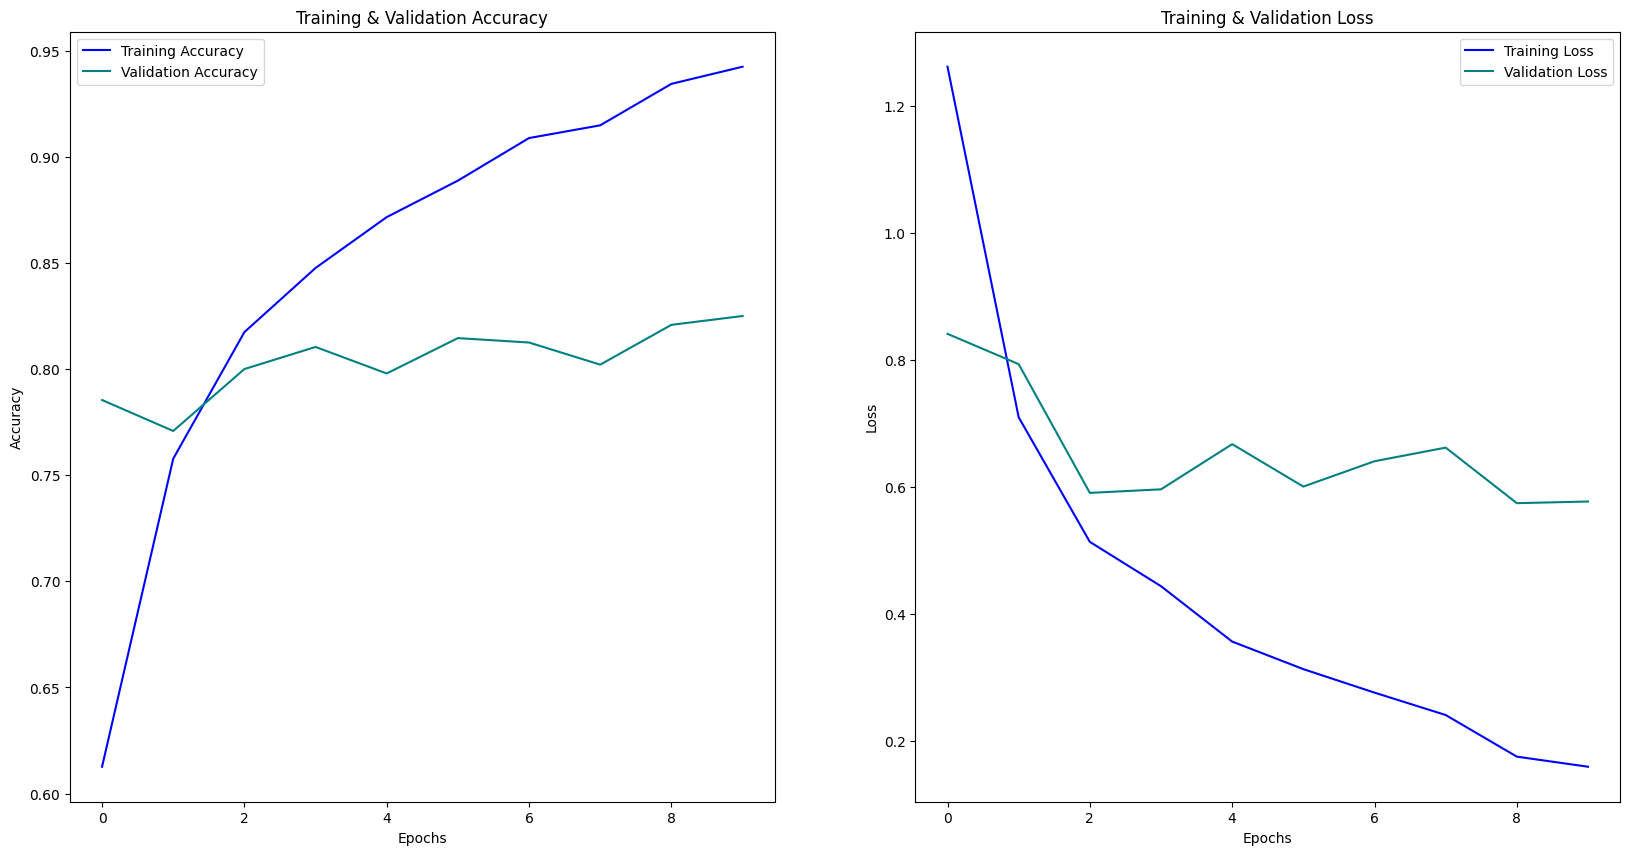

In [181]:
plot_accuracy_loss_chart(history1)

In [182]:
results = model.evaluate(test_images, test_labels)

print("Loss of the model is - ", results[0])
print("Accuracy of the model is - ", results[1]*100, "%")

15/15 [==============================] - 10s 657ms/step - loss: 0.5023 - accuracy: 0.8396
Loss of the model is -  0.5022528767585754
Accuracy of the model is -  83.95833373069763 %


In [183]:
from sklearn.metrics import classification_report
predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

15/15 [==============================] - 12s 656ms/step


array([0, 5, 7, 3, 6, 1, 4, 0, 3, 2, 1, 4, 6, 5, 5], dtype=int64)

In [184]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['BIO (Class 0)', 'Cardboard (Class 1)', 'Electronic (Class 2)', 'Glass (Class 3)', 'Metal (Class 4)', 'Paper (Class 5)', 'Plastic (Class 6)', 'Trash (Class 7)']))

                      precision    recall  f1-score   support

       BIO (Class 0)       0.96      0.90      0.93        58
 Cardboard (Class 1)       0.80      0.85      0.82        55
Electronic (Class 2)       0.90      1.00      0.94        60
     Glass (Class 3)       0.86      0.83      0.84        59
     Metal (Class 4)       0.93      0.83      0.88        64
     Paper (Class 5)       0.82      0.79      0.80        70
   Plastic (Class 6)       0.78      0.78      0.78        65
     Trash (Class 7)       0.67      0.73      0.70        49

            accuracy                           0.84       480
           macro avg       0.84      0.84      0.84       480
        weighted avg       0.84      0.84      0.84       480



In [185]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3', '4', '5', '6', '7'], columns = [['0', '1', '2', '3', '4', '5', '6', '7']])
cm

,0,1,2,3,4,5,6,7
0,52,0,0,0,0,0,0,6
1,0,47,2,0,0,5,1,0
2,0,0,60,0,0,0,0,0
3,0,0,0,49,2,0,7,1
4,0,0,2,1,53,1,4,3
5,0,5,3,0,1,55,2,4
6,0,3,0,6,1,0,51,4
7,2,4,0,1,0,6,0,36


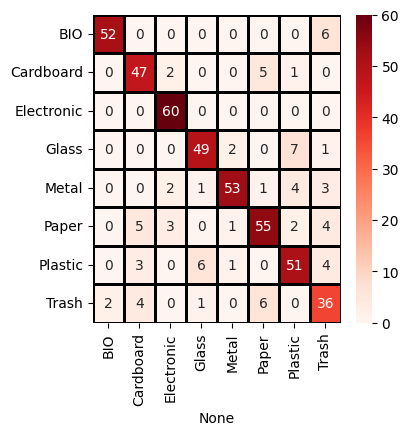

In [186]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (4,4))
    sns.heatmap(
        cm, 
        cmap = 'Reds', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)